In [16]:
import pandas as pd
import numpy as  np

df = pd.read_csv('swiggy_delivery_data.csv')
df.dropna(axis=0, how='all')
df.dropna(axis=1, how='all')

df['order_time'] = pd.to_datetime(df['order_time'], errors='coerce', format='%Y/%m/%d %H:%M')
df['delivery_time'] = pd.to_datetime(df['delivery_time'], errors='coerce', format='%d-%m-%Y %H:%M:%S')

In [17]:
df['Order_Hour'] = df['order_time'].dt.hour
df['Day'] = df['order_time'].dt.day
df['Day_Name'] = df['order_time'].dt.day_name()

def check_weekend(a):
    if (a['Day_Name']=="Saturday") or (a['Day_Name']=="Sunday"):
        return 1
    else:
        return 0

df['IS_WeekEnd'] = df.apply(lambda x : check_weekend(x), axis=1)
df['Order_Month'] = df['order_time'].dt.to_period("M")

df['Delivery_Duration'] = (df['delivery_time'] - df['order_time']).dt.total_seconds() / 60

In [18]:
Overall_average_delivery_duration = df['Delivery_Duration'].mean().item()

Cancellation_rate = (
    df[df['Cancelled (1/0)'] == 1]['order_id'].nunique() /
    df['order_id'].nunique()
) * 100

def check_delayed(a):
    if a['Delivery Delay (mins)']>=1:
        return 1
    else:
        return 0

df['Is_Delayed'] = df.apply(lambda x : check_delayed(x), axis=1)

percent_of_orders_delayed =( df[df['Is_Delayed']==1]['order_id'].nunique() / df['order_id'].nunique())*100


Average_customer_rating = (df[df['Customer Rating'] != "NIL"]['Customer Rating'].mean().item())

Zone_wise_delivery_duration_averages = df.groupby('zone', as_index=False)['Delivery_Duration'].mean()

Day_wise_cancellations = df[df['Cancelled (1/0)']==1].groupby('Day_Name', as_index=False)['order_id'].nunique()
Day_wise_orders = df.groupby('Day_Name', as_index=False)['order_id'].nunique()

a = pd.merge(Day_wise_cancellations, Day_wise_orders, on=['Day_Name'], how='inner')
a = a.rename(columns=({'order_id_x':'Cancelled_Orders','order_id_y':'Total_Orders'}))
a['Day_wise_cancel_percent'] = (a['Cancelled_Orders']/a['Total_Orders'])*100

Partner_wise_avg_delays = df[df['Is_Delayed']==1].groupby('delivery_partner', as_index=False)['Delivery Delay (mins)'].mean()
Restaurant_wise_rating_distribution = df.groupby('restaurant', as_index=False)['Customer Rating'].mean()

In [25]:
Zone_wise_cancellations = df[df['Cancelled (1/0)']==1].groupby('zone', as_index=False)['order_id'].nunique()
Zone_wise_orders = df.groupby('zone', as_index=False)['order_id'].nunique()

b = pd.merge(Zone_wise_cancellations,Zone_wise_orders, on=['zone'], how='inner')
b = b.rename(columns=({'order_id_x':'Cancelled_Orders','order_id_y':'Total_Orders'}))
b['Zone_wise_cancellations_Rate'] = (b['Cancelled_Orders']/b['Total_Orders'])*100

Hour_of_Day_vs_Average_Delivery_Delay = df[df['Is_Delayed']==1].groupby('Order_Hour', as_index=False)['Delivery Delay (mins)'].mean()

Day_of_Week_vs_Average_Customer_Rating = df.groupby('Day_Name', as_index=False)['Customer Rating'].mean().sort_values(by='Customer Rating')

Partner_wise_avg_delays['Rank1'] = Partner_wise_avg_delays['Delivery Delay (mins)'].rank(method='dense', ascending=True)
Partner_wise_avg_delays['Rank2'] = Partner_wise_avg_delays['Delivery Delay (mins)'].rank(method='dense', ascending=False)

Most_Reliable_DPs = Partner_wise_avg_delays[Partner_wise_avg_delays['Rank1']==1]['delivery_partner'].item()
Least_Reliable_DPs = Partner_wise_avg_delays[Partner_wise_avg_delays['Rank2']==1]['delivery_partner'].item()

Zone_Restaurant_Cross_Tab = df.groupby(['zone', 'restaurant'], as_index=False).agg(TO=('order_id','size'),CO=('Cancelled (1/0)','sum'),CR=('Customer Rating','mean'))
                                                            
Zone_Restaurant_Cross_Tab['Rank'] = Zone_Restaurant_Cross_Tab['CR'].rank(method='dense', ascending=True)

Poor_ZONE_RESTAURANT = Zone_Restaurant_Cross_Tab[Zone_Restaurant_Cross_Tab['Rank']==1][['zone','restaurant']]

c = df.groupby(['Order_Hour','Day_Name'], as_index=False)['Delivery Delay (mins)'].mean()
c['Is_Spike'] = c['Delivery Delay (mins)'].apply(lambda x : 1 if x >15 else 0)

Most_Delayed_Days = c.groupby(['Order_Hour','Day_Name'], as_index=False)['Is_Spike'].sum()
Most_Delayed_Days['Rank'] = Most_Delayed_Days['Is_Spike'].rank(method='dense', ascending=False)

MD_DH = Most_Delayed_Days[Most_Delayed_Days['Rank']==1][['Order_Hour','Day_Name']]
MD_DH = MD_DH.reset_index(drop=True)

In [157]:
MD_DH

,Order_Hour,Day_Name
0,9.0,Sunday


In [6]:
b

,zone,Cancelled_Orders,Total_Orders,Zone_wise_cancellations_Rate
0,Central,41,448,9.151786
1,East,28,412,6.796117
2,North,40,452,8.849558
3,South,32,441,7.256236
4,West,33,447,7.382550


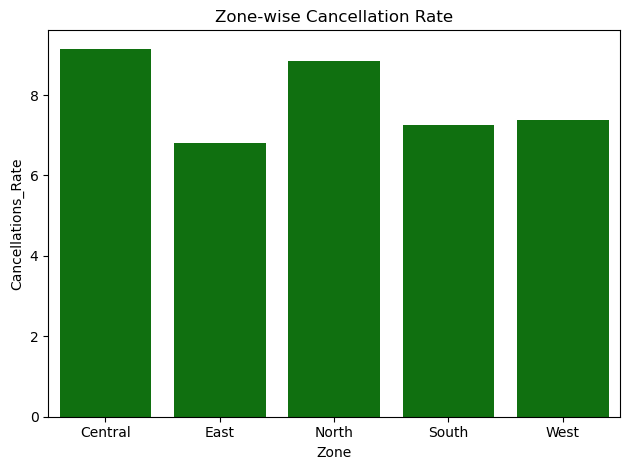

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(data=b, x='zone',y='Zone_wise_cancellations_Rate', color='green')
plt.xlabel("Zone")
plt.ylabel("Cancellations_Rate")
plt.title ("Zone-wise Cancellation Rate")
plt.tight_layout()
plt.show()

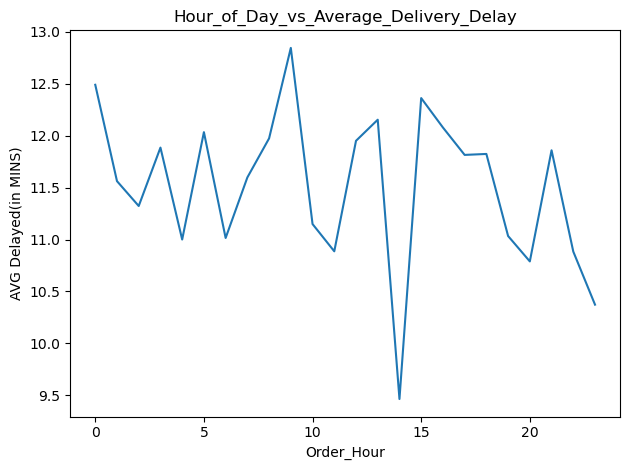

In [117]:
sns.lineplot(data=Hour_of_Day_vs_Average_Delivery_Delay, x='Order_Hour', y='Delivery Delay (mins)')
plt.xlabel("Order_Hour")
plt.ylabel("AVG Delayed(in MINS)")
plt.title ("Hour_of_Day_vs_Average_Delivery_Delay")
plt.tight_layout()
plt.show()

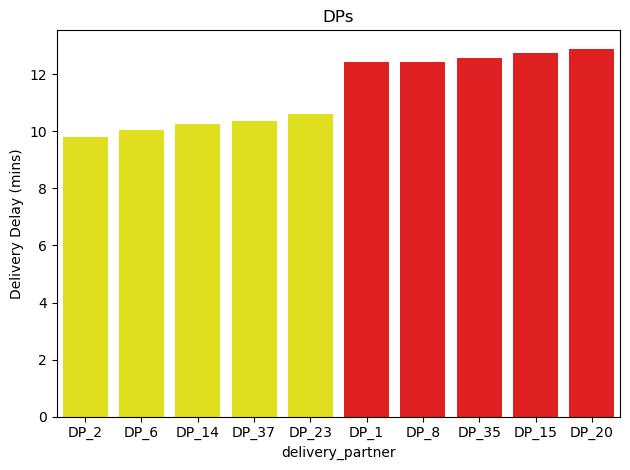

In [137]:
Partner_wise_avg_delays

Reliable_DPs = Partner_wise_avg_delays[Partner_wise_avg_delays['Rank1']<=5].reset_index(drop=True).sort_values(by='Delivery Delay (mins)')
Non_Reliable_DPs = Partner_wise_avg_delays[Partner_wise_avg_delays['Rank2']<=5].reset_index(drop=True).sort_values(by='Delivery Delay (mins)')

sns.barplot(data=Reliable_DPs, x='delivery_partner',y='Delivery Delay (mins)', color='yellow')
sns.barplot(data=Non_Reliable_DPs, x='delivery_partner',y='Delivery Delay (mins)', color='red')
plt.xlabel("delivery_partner")
plt.ylabel("Delivery Delay (mins)")
plt.title ("DPs")
plt.tight_layout()
plt.show()

In [138]:
Reliable_DPs

,delivery_partner,Delivery Delay (mins),Rank1,Rank2
1,DP_2,9.787234,1.0,39.0
4,DP_6,10.040000,2.0,38.0
0,DP_14,10.276596,3.0,37.0
3,DP_37,10.357143,4.0,36.0
2,DP_23,10.600000,5.0,35.0


C:\Users\Dell\AppData\Local\Temp\ipykernel_12788\2305029602.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=Day_of_Week_vs_Average_Customer_Rating, x='Day_Name',y='Customer Rating', palette=diff_colors)


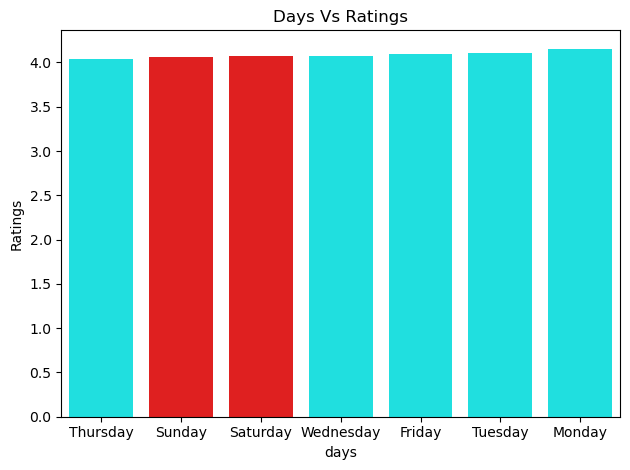

In [158]:
diff_colors = []
for d in Day_of_Week_vs_Average_Customer_Rating['Day_Name']:
    if (d=="Saturday") or (d=="Sunday"):
        diff_colors.append('red')
    else:
        diff_colors.append('aqua')
    

sns.barplot(data=Day_of_Week_vs_Average_Customer_Rating, x='Day_Name',y='Customer Rating', palette=diff_colors)
plt.xlabel("days")
plt.ylabel("Ratings")
plt.title ("Days Vs Ratings")
plt.tight_layout()
plt.show()

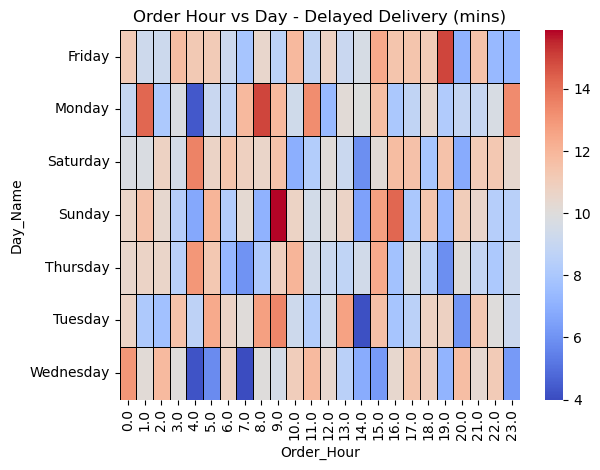

In [165]:
c = c.copy()
hm_data = c.pivot(
    index='Day_Name',
    columns='Order_Hour',
    values='Delivery Delay (mins)')

sns.heatmap(hm_data, annot=False, cmap='coolwarm', linewidths=0.5, linecolor='black')
plt.title("Order Hour vs Day - Delayed Delivery (mins)")
plt.tight_layout()
plt.show()

In [151]:
c

,Order_Hour,Day_Name,Day,Delivery Delay (mins),Is_Spike,Day_Num
0,0.0,Friday,7.0,17.000000,1,4
1,0.0,Friday,14.0,16.000000,1,4
2,0.0,Friday,21.0,4.666667,0,4
3,0.0,Friday,28.0,11.000000,0,4
4,0.0,Monday,3.0,8.000000,0,0
...,...,...,...,...,...,...
681,23.0,Tuesday,25.0,11.000000,0,1
682,23.0,Wednesday,5.0,11.500000,0,2
683,23.0,Wednesday,12.0,1.000000,0,2
684,23.0,Wednesday,19.0,7.000000,0,2


In [45]:
Zone_Restaurant_Cross_Tab['Cancelled_Rate'] = (Zone_Restaurant_Cross_Tab['CO']/Zone_Restaurant_Cross_Tab['TO'])*100


Zone_Restaurant_Cross_Tab['Zone_Restaurant'] = Zone_Restaurant_Cross_Tab['zone'] + ' - ' + Zone_Restaurant_Cross_Tab['restaurant']

Zone_Restaurant_Cross_Tab['Low_Rating_Rank'] = Zone_Restaurant_Cross_Tab['CR'].rank(ascending=True)
Zone_Restaurant_Cross_Tab['High_Cancel_Rank'] = Zone_Restaurant_Cross_Tab['Cancelled_Rate'].rank(ascending=False)

In [46]:
Zone_Restaurant_Cross_Tab

,zone,restaurant,TO,CO,CR,Rank,Cancelled_Rate,Zone_Restaurant,Low_Rating_Rank,High_Cancel_Rank
0,Central,Restaurant_1,14,2,4.107143,69.0,14.285714,Central - Restaurant_1,79.0,29.5
1,Central,Restaurant_10,15,0,3.923077,20.0,0.000000,Central - Restaurant_10,21.0,125.5
2,Central,Restaurant_11,12,1,4.191667,103.0,8.333333,Central - Restaurant_11,123.0,62.0
3,Central,Restaurant_12,17,2,4.112500,72.0,11.764706,Central - Restaurant_12,82.0,39.5
4,Central,Restaurant_13,16,2,4.078571,63.0,12.500000,Central - Restaurant_13,72.0,35.5
...,...,...,...,...,...,...,...,...,...,...
145,West,Restaurant_5,16,1,3.864286,12.0,6.250000,West - Restaurant_5,12.0,85.5
146,West,Restaurant_6,14,4,3.900000,17.0,28.571429,West - Restaurant_6,17.5,3.0
147,West,Restaurant_7,7,0,4.000000,41.0,0.000000,West - Restaurant_7,44.0,125.5
148,West,Restaurant_8,17,4,4.153333,87.0,23.529412,West - Restaurant_8,103.0,5.0


In [50]:
Poor_Zone_Rest = Zone_Restaurant_Cross_Tab[(Zone_Restaurant_Cross_Tab['High_Cancel_Rank']<=10) & (Zone_Restaurant_Cross_Tab['Low_Rating_Rank']<=10)]

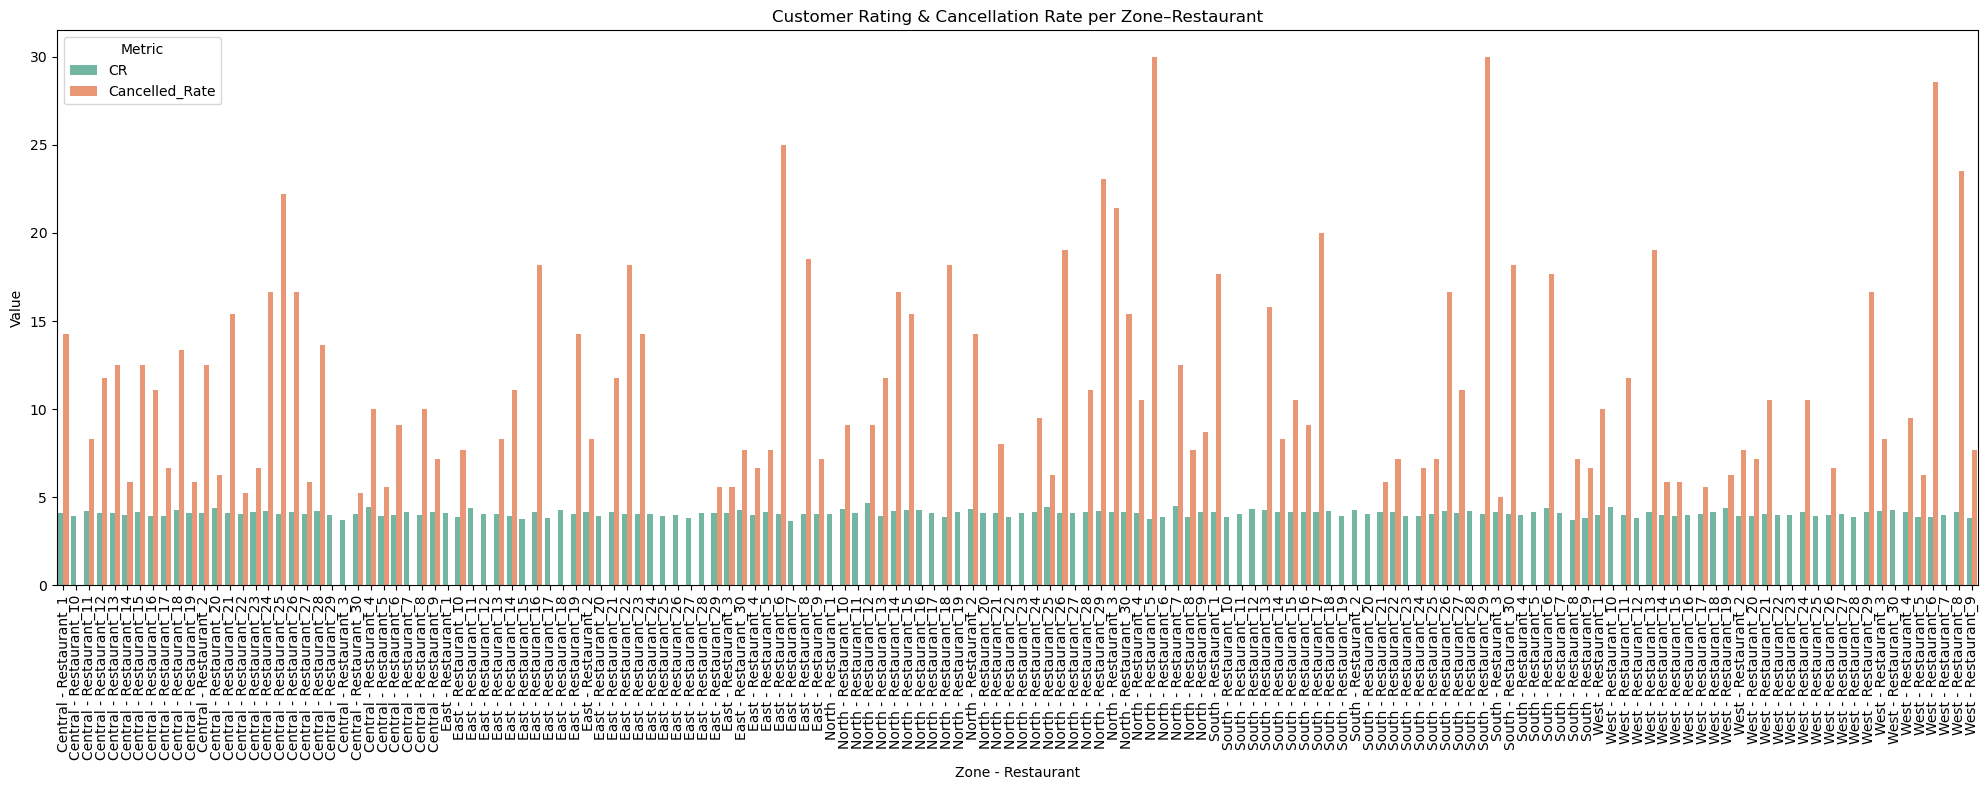

In [58]:
plot_Zone_res = Zone_Restaurant_Cross_Tab.melt(id_vars='Zone_Restaurant',value_vars=['CR', 'Cancelled_Rate'],var_name='Metric',value_name='Value')
plt.figure(figsize=(20, 8))
sns.barplot(data=plot_Zone_res, x='Zone_Restaurant', y='Value', hue='Metric', palette='Set2')
plt.xticks(rotation=90)
plt.title('Customer Rating & Cancellation Rate per Zone–Restaurant')
plt.ylabel("Value")
plt.xlabel("Zone - Restaurant")
plt.tight_layout()
plt.show()

In [68]:
Week_end = df[df['IS_WeekEnd']==1].groupby('Day_Name', as_index=False).agg(DD=('Delivery Delay (mins)','mean'),TO=('order_id','size'),CO=('Cancelled (1/0)','sum'),CR=('Customer Rating','mean'))
Week_end['Cancel_Rate'] = (Week_end['CO']/Week_end['TO'])*100

Week_day = df[df['IS_WeekEnd']==0].groupby('Day_Name', as_index=False).agg(DD=('Delivery Delay (mins)','mean'),TO=('order_id','size'),CO=('Cancelled (1/0)','sum'),CR=('Customer Rating','mean'))
Week_day['Cancel_Rate'] = (Week_day['CO']/Week_day['TO'])*100                                                  

In [69]:
Week_end

,Day_Name,DD,TO,CO,CR,Cancel_Rate
0,Saturday,9.845333,375,27,4.072853,7.200000
1,Sunday,9.945783,332,21,4.066445,6.325301


In [70]:
Week_day

,Day_Name,DD,TO,CO,CR,Cancel_Rate
0,Friday,10.226537,309,31,4.090301,10.032362
1,Monday,9.963576,302,28,4.155401,9.271523
2,Thursday,9.445230,283,14,4.040293,4.946996
3,Tuesday,9.884746,295,23,4.103534,7.796610
4,Wednesday,9.513514,259,27,4.073878,10.424710


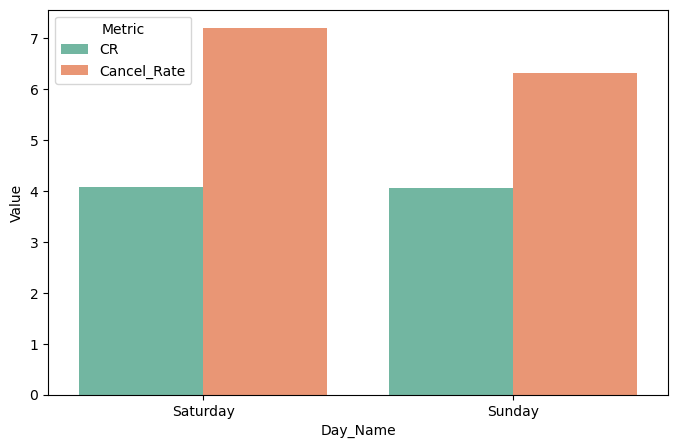

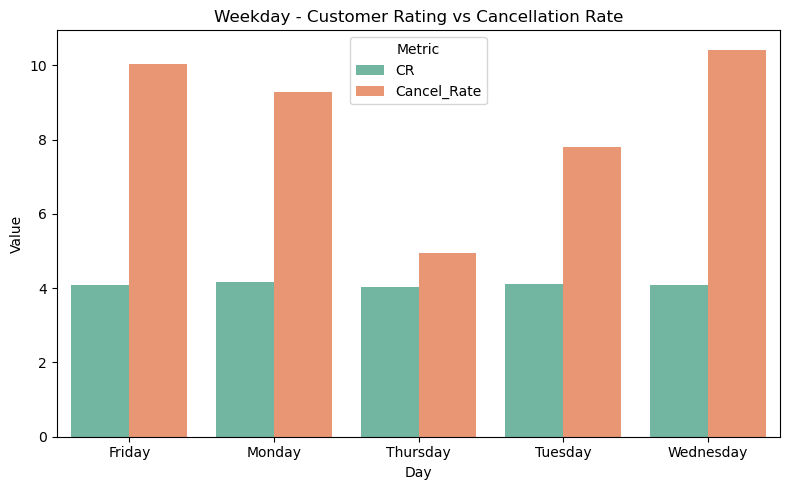

In [77]:
plot_WE = Week_end.melt(id_vars='Day_Name', value_vars=['CR', 'Cancel_Rate'],
                        var_name='Metric', value_name='Value')
plot_WD = Week_day.melt(id_vars='Day_Name', value_vars=['CR', 'Cancel_Rate'],
                        var_name='Metric', value_name='Value')
plt.figure(figsize=(8, 5))
sns.barplot(data=plot_WE, x='Day_Name', y='Value', hue='Metric', palette='Set2')
plt.figure(figsize=(8, 5))
sns.barplot(data=plot_WD, x='Day_Name', y='Value', hue='Metric', palette='Set2')
plt.title("Weekend - Customer Rating vs Cancellation Rate")
plt.title("Weekday - Customer Rating vs Cancellation Rate")
plt.ylabel("Value")
plt.xlabel("Day")
plt.tight_layout()
plt.show()